In [1]:
import math
import pandas as pd
import numpy as np
from lssvr import LSSVR
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from gc_aux import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

In [2]:
# load the data
df_raw = pd.read_excel('data/LFVL_v2.xlsx')
df_val_test_raw = pd.read_excel('data/val_test.xlsx')
#splitting the train set and val/test set
duplicates = df_raw['SMILES'].isin(df_val_test_raw['SMILES'])
df_train = df_raw[~duplicates]
df_val_test = df_raw[duplicates]

In [5]:
df_train_raw = df_train
df_val_test_raw = df_val_test

In [4]:
prop_tag = 'Pc'
df_raw = pd.read_excel('data/excels/Pc.xlsx')

df_train, df_val_test = train_test_split(df_raw, test_size=0.4, random_state=30)

In [5]:
from sklearn.utils import shuffle

#re splitting the train and val/test set
total_rows = len(df_train) + len(df_val_test)
target_rows_80 = int(total_rows * 0.8)
target_rows_85 = int(total_rows * 0.85)
target_rows_90 = int(total_rows * 0.9)
target_rows_95 = int(total_rows * 0.95)

def split_datasets(df_train, df_val_test, target_rows):
    df_val_test_randomized = shuffle(df_val_test, random_state=0)
    
    rows_to_transfer = target_rows - len(df_train)
    
    df_train_new = pd.concat([df_train, df_val_test_randomized.iloc[:rows_to_transfer]])
    df_val_test_new = df_val_test_randomized.iloc[rows_to_transfer:]
    
    return df_train_new, df_val_test_new

df_train_80, df_val_test_80 = split_datasets(df_train, df_val_test, target_rows_80)
df_train_85, df_val_test_85 = split_datasets(df_train, df_val_test, target_rows_85)
df_train_90, df_val_test_90 = split_datasets(df_train, df_val_test, target_rows_90)
df_train_95, df_val_test_95 = split_datasets(df_train, df_val_test, target_rows_95)

In [6]:
df_to_move = df_val_test_95[df_val_test_95['SMILES'] == 'O=CO']
row_to_move = df_train_95.iloc[[-1]]

df_train_95 = df_train_95.drop(row_to_move.index)
df_train_95 = pd.concat([df_train_95, df_to_move], ignore_index=True)

df_val_test_95 = df_val_test_95[df_val_test_95['SMILES'] != 'O=CO']
df_val_test_95 = pd.concat([df_val_test_95, row_to_move], ignore_index=True)

df_train_95.to_csv('data/df_train_95.csv', index=False)

In [7]:
#preparing the train set
df_train = df_train_95

const_value_index = df_train.columns.get_loc("Const_Value")

df_train.insert(loc=const_value_index + 1, column='Pred_Fog', value=0)
df_train.insert(loc=const_value_index + 2, column='Pred_Sog', value=0)
df_train.insert(loc=const_value_index + 3, column='Pred_Tog', value=0)

df_target = df_train['Const_Value']
df_grp = df_train.loc[:,'CH3':]

# G_train = df_grp.to_numpy()
fog_train = df_grp.to_numpy()[:,:220]
y_train = df_target.to_numpy()

In [8]:
#preparing the val/test set
df_val_test = df_val_test_95

df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=42)

df_val.insert(loc=const_value_index + 1, column='Pred_Fog', value=0)
df_val.insert(loc=const_value_index + 2, column='Pred_Sog', value=0)
df_val.insert(loc=const_value_index + 3, column='Pred_Tog', value=0)

df_test.insert(loc=const_value_index + 1, column='Pred_Fog', value=0)
df_test.insert(loc=const_value_index + 2, column='Pred_Sog', value=0)
df_test.insert(loc=const_value_index + 3, column='Pred_Tog', value=0)

#preparing val set
df_val_grp = df_val.loc[:,'CH3':]
fog_val = df_val_grp.to_numpy()[:,:220]
y_val = df_val['Const_Value'].to_numpy()

#preparing test set
df_test_grp = df_test.loc[:,'CH3':]
fog_test = df_test_grp.to_numpy()[:,:220]
y_test = df_test['Const_Value'].to_numpy()

first-order groups

In [9]:
#define the scaler
scaler_fog = StandardScaler()
#fit the scaler
scaler_fog.fit(y_train.reshape(-1, 1))
#apply scaler
ys_train_fog = scaler_fog.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)
ys_val_fog = scaler_fog.transform(y_val.reshape(-1, 1)).reshape(y_val.size,)
ys_test_fog = scaler_fog.transform(y_test.reshape(-1, 1)).reshape(y_test.size,)

In [10]:
svr_fog = LSSVR(kernel='rbf')
svr_fog.fit(fog_train, ys_train_fog)
ys_pred_test_0 = svr_fog.predict(fog_test)
y_pred_test_0 = scaler_fog.inverse_transform(ys_pred_test_0.reshape(-1, 1)).reshape(ys_pred_test_0.size)

print('MAE', mean_absolute_error(y_test, y_pred_test_0))
print('R2 score',svr_fog.score(fog_test, y_test))

MAE 3.0546320995391794
R2 score 0.9087933844800676


In [11]:
param_grid = {
    'C': np.arange(1, 40),
    'gamma': np.linspace(0.01, 0.5, 50)
}

grid_search = GridSearchCV(LSSVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(fog_val, y_val)

print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 39, 'gamma': 0.01}


In [12]:
#results on train set with only first-order groups
best_svr_fog = LSSVR(
    kernel='rbf',
    gamma = grid_search.best_params_['gamma'],
    C = grid_search.best_params_['C']
)

best_svr_fog.fit(fog_train, ys_train_fog)

ys_pred_test_fog = best_svr_fog.predict(fog_test)
y_pred_test_fog = scaler_fog.inverse_transform(ys_pred_test_fog.reshape(-1, 1)).reshape(ys_pred_test_fog.size)

print('MAE', mean_absolute_error(y_test, y_pred_test_fog))
print('R2 score',best_svr_fog.score(fog_test, y_test))

MAE 1.9061404486420044
R2 score 0.9561974843585469


In [13]:
ys_pred_train_fog = best_svr_fog.predict(fog_train)
y_pred_train_fog = scaler_fog.inverse_transform(ys_pred_train_fog.reshape(-1, 1)).reshape(ys_pred_train_fog.size)
ys_pred_val_fog = best_svr_fog.predict(fog_val)
y_pred_val_fog = scaler_fog.inverse_transform(ys_pred_val_fog.reshape(-1, 1)).reshape(ys_pred_val_fog.size)

print('MAE', mean_absolute_error(y_train, y_pred_train_fog))
print('R2 score',best_svr_fog.score(fog_train, y_train))

MAE 1.7329652666226274
R2 score 0.9405564437794801


In [16]:
import pickle

filename = f'svr_fog_' + prop_tag + '.pkl'

saved_objects = {
    'model': best_svr_fog,
}

with open(filename, 'wb') as file:
    pickle.dump(saved_objects, file)

print(f'Model saved as {filename}')

Model saved as svr_fog_Pc.pkl


second-order groups

In [27]:
df_train['Pred_Fog'] = y_pred_train_fog
df_val['Pred_Fog'] = y_pred_val_fog
df_test['Pred_Fog'] = y_pred_test_fog

In [115]:
df_train_sog = df_train.loc[(df_grp.iloc[:,220:220+130]!=0).any(axis=1)]
sog_train_grp = df_train_sog.loc[:,'CH3':]
sog_train = sog_train_grp.iloc[:,220:220+130].to_numpy()
y_train_sog = df_train_sog['Const_Value'].to_numpy()

df_val_sog = df_val.loc[(df_val_grp.iloc[:,220:220+130]!=0).any(axis=1)]
sog_val_grp = df_val_sog.loc[:,'CH3':]
sog_val = sog_val_grp.iloc[:,220:220+130].to_numpy()
y_val_sog = df_val_sog['Const_Value'].to_numpy()

df_test_sog = df_test.loc[(df_test_grp.iloc[:,220:220+130]!=0).any(axis=1)]
sog_test_grp = df_test_sog.loc[:,'CH3':]
sog_test = sog_test_grp.iloc[:,220:220+130].to_numpy()
y_test_sog = df_test_sog['Const_Value'].to_numpy()

In [116]:
sog_train

array([[2, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [99]:
diff_train_sog = y_train_sog - df_train_sog['Pred_Fog'].to_numpy()
diff_val_sog =  y_val_sog - df_val_sog['Pred_Fog'].to_numpy()
diff_test_sog =  y_test_sog - df_test_sog['Pred_Fog'].to_numpy()

#the difference between the true value and predicted value from first order groups are not that huge, thus the scaler is not
#applied here

In [100]:
svr_sog = LSSVR(kernel='rbf')
svr_sog.fit(sog_train, diff_train_sog)
y_pred_test = svr_sog.predict(sog_test)

print('MAE', mean_absolute_error(diff_test_sog, y_pred_test))
print('R2 score',svr_sog.score(sog_test, diff_test_sog))

MAE 0.44797168978051116
R2 score 1.0


In [88]:
param_grid = {
    'C': np.arange(1, 40),
    'gamma': np.linspace(0.01, 0.5, 50)
}

grid_search = GridSearchCV(LSSVR(kernel='rbf'), param_grid, cv=2)
grid_search.fit(sog_val, diff_val_sog)

print("Best parameters: ", grid_search.best_params_)

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Users\49332\anaconda3\envs\test\lib\site-packages\scipy\stats\_stats_py.py:4424: Constant

Best parameters:  {'C': 1, 'gamma': 0.01}


C:\Users\49332\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


In [89]:
grid_search.best_params_

{'C': 1, 'gamma': 0.01}

In [90]:
best_svr_sog = LSSVR(
    kernel='rbf',
    gamma = grid_search.best_params_['gamma'],
    C = grid_search.best_params_['C']
)

best_svr_sog.fit(sog_train, diff_train_sog)

diff_pred_test_sog = svr_sog.predict(sog_test)
diff_pred_train_sog = svr_sog.predict(sog_train)
diff_pred_val_sog = svr_sog.predict(sog_val)

print('MAE', mean_absolute_error(diff_test_sog, diff_pred_test_sog))
print('R2 score',best_svr_sog.score(sog_test, diff_test_sog))

MAE 0.44797168978051116
R2 score 1.0


In [91]:
mae_sog = mean_absolute_error(y_test_sog, df_test_sog['Pred_Fog'].to_numpy()+diff_pred_test_sog)
r2_sog = r2_score(y_test_sog, df_test_sog['Pred_Fog'].to_numpy()+diff_pred_test_sog)

print("MAE on test set:", mae_sog)
print("R2 on test set:", r2_sog)

MAE on test set: 0.44797168978051116
R2 on test set: 1.0


third-order groups

In [64]:
df_train_sog['Pred_Sog'] = diff_pred_train_sog
df_val_sog['Pred_Sog'] = diff_pred_val_sog
df_test_sog['Pred_Sog'] = diff_pred_test_sog

C:\Users\49332\AppData\Local\Temp\ipykernel_9196\2318193959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_sog['Pred_Sog'] = diff_pred_train_sog
C:\Users\49332\AppData\Local\Temp\ipykernel_9196\2318193959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_sog['Pred_Sog'] = diff_pred_val_sog
C:\Users\49332\AppData\Local\Temp\ipykernel_9196\2318193959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [65]:
sog_mapping_train = df_train_sog.set_index('SMILES')['Pred_Sog'].to_dict()
df_train['Pred_Sog'] = df_train['SMILES'].map(sog_mapping_train)
df_train['Pred_Sog'].fillna(0, inplace=True)

sog_mapping_val = df_val_sog.set_index('SMILES')['Pred_Sog'].to_dict()
df_val['Pred_Sog'] = df_val['SMILES'].map(sog_mapping_val)
df_val['Pred_Sog'].fillna(0, inplace=True)

sog_mapping_test = df_test_sog.set_index('SMILES')['Pred_Sog'].to_dict()
df_test['Pred_Sog'] = df_test['SMILES'].map(sog_mapping_test)
df_test['Pred_Sog'].fillna(0, inplace=True)

In [121]:
df_train_tog = df_train.loc[(df_grp.iloc[:,220+130:]!=0).any(axis=1)]
tog_train_grp = df_train_tog.loc[:,'CH3':]
tog_train = tog_train_grp.iloc[:,220+130:].to_numpy()
y_train_tog = df_train_tog['Const_Value'].to_numpy()

df_val_tog = df_val.loc[(df_val_grp.iloc[:,220+130:]!=0).any(axis=1)]
tog_val_grp = df_val_tog.loc[:,'CH3':]
tog_val = tog_val_grp.iloc[:,220+130:].to_numpy()
y_val_tog = df_val_tog['Const_Value'].to_numpy()

df_test_tog = df_test.loc[(df_test_grp.iloc[:,220+130:]!=0).any(axis=1)]
tog_test_grp = df_test_tog.loc[:,'CH3':]
tog_test = tog_test_grp.iloc[:,220+130:220+130+74].to_numpy()
y_test_tog = df_test_tog['Const_Value'].to_numpy()

#if there is no value in the dataframe of validation, but there are values in the test set, then use test set for 
#the validation

In [122]:
diff_train_tog = y_train_tog - df_train_tog['Pred_Fog'].to_numpy() - df_train_tog['Pred_Sog'].to_numpy()
diff_val_tog =  y_test_tog - df_test_tog['Pred_Fog'].to_numpy() - df_test_tog['Pred_Sog'].to_numpy()

In [123]:
diff_val_tog

array([], dtype=float64)

In [130]:
svr_tog = LSSVR(kernel='rbf')
svr_tog.fit(tog_train, diff_train_tog)
y_pred_test = svr_tog.predict(tog_train)

print('MAE', mean_absolute_error(diff_train_tog, y_pred_test))
print('R2 score', r2_score(diff_train_tog, y_pred_test))

MAE 0.13471949854392223
R2 score 0.2812143333831288


In [134]:
param_grid = {
    'C': np.arange(1, 40),
    'gamma': np.linspace(0.01, 0.5, 50)
}

grid_search = GridSearchCV(LSSVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(tog_train, diff_train_tog)

print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 4, 'gamma': 0.09999999999999999}


In [136]:
best_svr_tog = LSSVR(
    kernel='rbf',
    gamma = grid_search.best_params_['gamma'],
    C = grid_search.best_params_['C']
)

best_svr_tog.fit(tog_train, diff_train_tog)

diff_pred_train_tog = best_svr_tog.predict(tog_train)

print('MAE', mean_absolute_error(diff_train_tog, diff_pred_train_tog))
print('R2 score', r2_score(diff_train_tog, diff_pred_train_tog))

MAE 0.09544078275333358
R2 score 0.4881701794794565


In [137]:
df_train_tog['Pred_Tog'] = diff_pred_train_tog

C:\Users\49332\AppData\Local\Temp\ipykernel_9196\3489636013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_tog['Pred_Tog'] = diff_pred_train_tog


In [138]:
tog_mapping_train = df_train_tog.set_index('SMILES')['Pred_Tog'].to_dict()
df_train['Pred_Tog'] = df_train['SMILES'].map(tog_mapping_train)
df_train['Pred_Tog'].fillna(0, inplace=True)

In [139]:
df_eva_train = df_train[['SMILES', 'Const_Value', 'Pred_Fog', 'Pred_Sog', 'Pred_Tog']] 
df_eva_val = df_val[['SMILES', 'Const_Value', 'Pred_Fog', 'Pred_Sog', 'Pred_Tog']] 
df_eva_test = df_test[['SMILES', 'Const_Value', 'Pred_Fog', 'Pred_Sog', 'Pred_Tog']] 

final results evaluating

In [140]:
#metrics
y_pred_train = df_train['Pred_Fog'].to_numpy()+df_train['Pred_Sog'].to_numpy()+df_train['Pred_Tog'].to_numpy()
y_pred_val = df_val['Pred_Fog'].to_numpy()+df_val['Pred_Sog'].to_numpy()+df_val['Pred_Tog'].to_numpy()
y_pred_test = df_test['Pred_Fog'].to_numpy()+df_test['Pred_Sog'].to_numpy()+df_test['Pred_Tog'].to_numpy()

In [141]:
print("MAE on train set:", mean_absolute_error(y_train, y_pred_train))
print("R2 on train set:", r2_score(y_train, y_pred_train))

print("MAE on validation set:", mean_absolute_error(y_val, y_pred_val))
print("R2 on validation set:", r2_score(y_val, y_pred_val))

print("MAE on test set:", mean_absolute_error(y_test, y_pred_test))
print("R2 on test set:", r2_score(y_test, y_pred_test))

MAE on train set: 0.5242273622340959
R2 on train set: 0.7617872818787101
MAE on validation set: 0.3302565817903973
R2 on validation set: 0.5756313523263495
MAE on test set: 0.5186176318835004
R2 on test set: 0.8455538326074626


In [149]:
df_eva_val

,SMILES,Const_Value,Pred_Fog,Pred_Sog,Pred_Tog
3,COCCOC,1.60,2.464017,0.000000,0
4,OCCCCCCCCC,0.68,0.685186,0.000000,0
18,OCC(CC)CC,1.20,0.976837,0.000000,0
16,O=C(C)CC(O)(C)C,1.80,1.394616,-0.197020,0
21,CCCCCCCC(=O)C,0.82,0.465721,-0.203680,0
22,N#CCCC,1.57,2.273092,0.000000,0
7,NCCCC,1.70,1.696823,0.000000,0
10,CCc1ccc(CC)cc1,0.80,1.133073,-0.158295,0
14,CCC(C)(C)C,1.20,1.084281,-0.163272,0
19,OCCCCCCCC,0.84,0.741140,0.000000,0


In [145]:
y_pred_val

array([2.46401662, 0.68518596, 0.97683655, 1.19759589, 0.26204112,
       2.27309216, 1.69682323, 0.97477851, 0.9210092 , 0.74113955,
       0.83880529])

In [146]:
y_test

array([1.2 , 0.76, 1.05, 0.96, 7.3 , 1.8 , 1.9 , 2.6 , 1.4 , 2.6 , 2.  ,
       4.67])

In [147]:
y_pred_test

array([1.11207191, 0.33431226, 0.53519168, 0.57886494, 5.33882802,
       2.25222662, 2.85859402, 2.75193169, 1.32697857, 3.17448624,
       2.3370169 , 4.9754035 ])

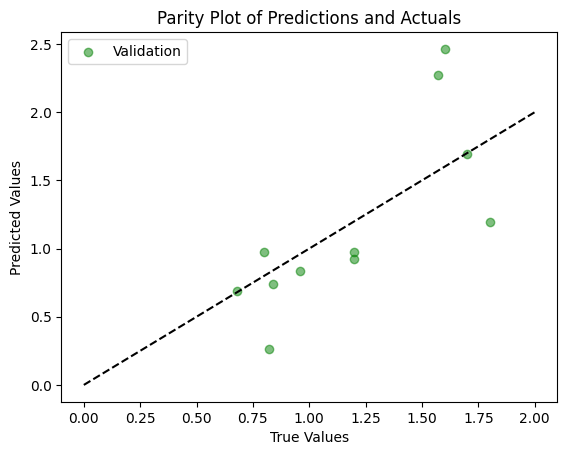

In [150]:
plt.scatter(y_val, y_pred_val, color='green', alpha=0.5, label='Validation')

plt.plot([0, 2], [0, 2], color='black', linestyle='--')

plt.legend()

plt.title('Parity Plot of Predictions and Actuals')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


plt.show()

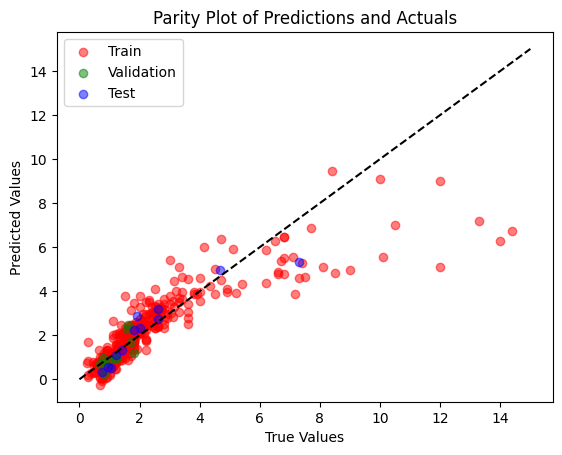

In [151]:
plt.scatter(y_train, y_pred_train, color='red', alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, color='green', alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5, label='Test')

plt.plot([0, 15], [0, 15], color='black', linestyle='--')

plt.legend()

plt.title('Parity Plot of Predictions and Actuals')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


plt.show()

ends here